

- Transfer Learning with TF 2.0 (https://towardsdatascience.com/transfer-learning-with-tf-2-0-ff960901046d)
- Models pre-trained on ImageNet (https://keras.io/applications/)


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np
import shutil
from random import shuffle
import os
import pathlib
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [83]:
!ls "MODEL1/train/SAFE" | wc -l
!ls "MODEL1/train/ACCIDENTS" | wc -l
!ls "MODEL1/test/SAFE" | wc -l
!ls "MODEL1/test/ACCIDENTS" | wc -l
!rm 'drive/My Drive/models/*'
!rm 'drive/My Drive/history/*'

30335
30335
7584
7584
rm: cannot remove 'drive/My Drive/models/*': No such file or directory
rm: cannot remove 'drive/My Drive/history/*': No such file or directory


In [90]:
!ls "drive/My Drive/models"

mobilenet_v2.hdf5


In [20]:
!tar -xvf  'drive/My Drive/datasets/MODEL1/model1.tar.gz' 


Streaming output truncated to the last 5000 lines.
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.54050254517096_40.54230361665938.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.801652028517545_40.80345301828673.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.81425894505862_40.816059930880016.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_40.87909407928082_40.88089504479551.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.00696122859242_41.008762154039246.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.042979630266906_41.04478054442266.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.09880770653381_41.100608603184696.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.36713507815293_41.36893589060661.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.392346401050474_41.394147205588006.jpg
MODEL1/train/SAFE/-8.616509056606878_-8.614267744792592_41.66246076022465_41.6

### Using image sizes of 224x224 with 3 channels (This is the default of the pre-trained model we are going to use, and so it's a good idea to keep the same sizes, because those where used to train them most-likely but other sizes can be used without much problem)

### Also the 80% / 20% split was used for trainning and validation

In [21]:
NCLASSES = 2
HEIGHT = 128
WIDTH = 128
NUM_CHANNELS = 3
BATCH_SIZE = 32
TRAIN_PERC = 0.8
TEST_PERC = 0.2
PATH = "MODEL1"
TRAIN_DIRECTORY="MODEL1/train"
TEST_DIRECTORY="MODEL1/test"
CATEGORIES= os.listdir(TRAIN_DIRECTORY)
DATA_SET_COUNT = sum([len(os.listdir(f"{TRAIN_DIRECTORY}/{x}")) for x in CATEGORIES])
TEST_SET_COUNT = sum([len(os.listdir(f"{TEST_DIRECTORY}/{x}")) for x in CATEGORIES])
TRAIN_SET_COUNT = (DATA_SET_COUNT) * TRAIN_PERC
VAL_SET_COUNT = (DATA_SET_COUNT) * TEST_PERC
METRICS = [metrics.categorical_accuracy]
print(TRAIN_SET_COUNT, VAL_SET_COUNT)

48536.0 12134.0


Load a model from keras database (https://keras.io/applications/) with weights trained on ImageNet

Note that the *image_top* parameter is set to *true*. This implies that we are only keeping the convolutional layers of the network

### The MobileNetV2 was chosen, it was developed by Google and it's an architecture that was suposed to bring neural networks to mobile, and because of that it should be not only good but fast and require less resoucers than others .

In [22]:
#base_model = tf.keras.applications.vgg19.VGG19(input_shape=(HEIGHT, WIDTH, NUM_CHANNELS), include_top=False, weights='imagenet')
#base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False,weights=None, input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,weights=None, input_shape=(HEIGHT, WIDTH, NUM_CHANNELS))
MODEL_FILE="mobilenet_v2.hdf5"
MODEL_HISTORY=f"drive/My Drive/history/{MODEL_FILE}"

print(base_model.summary())

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

Freeze the preloaded weights, these won't be used for training
comment the line below to train the full network

In [23]:
#base_model.trainable = False

Add new layers to the top of the network

Global Average Pooling (GAP) performs an average for each of the feature maps. Assuming the last conv layer is 3x3x256, we have 256 feature maps. Global average pooling is a layer with 256 values, each being the average of a feature map.

Original paper for Global Average Pooling: Network In Network, Min Lin1, Qiang Chen, Shuicheng Yan (https://arxiv.org/pdf/1312.4400.pdf). Note the GAP is not the main theme of the paper.

In [24]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dense(2, activation='softmax')(x)

model_3 = models.Model(inputs=base_model.input, outputs=x)
print(model_3.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

Auxiliary function for loading the dataset

#### Changed to deal with JPEG and resize the images, because they have varying sizes and we want them to be all 224x224 with 3 channels

In [25]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [26]:

data_dir = pathlib.Path(TRAIN_DIRECTORY)
  
classNames = np.array(os.listdir(data_dir))
classNames

AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(f"{TRAIN_DIRECTORY}/*/*.jpg")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


In [27]:
classNames

array(['ACCIDENTS', 'SAFE'], dtype='<U9')

Split the dataset into training and validation sets

In [28]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.repeat()

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)
train_dataset = dataset.take(train_size)
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.repeat();
val_dataset = dataset.skip(train_size)
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.repeat();

Load the test set

In [29]:
testset = tf.data.Dataset.list_files(f"{TEST_DIRECTORY}/*/*.jpg")
testset = testset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size=BATCH_SIZE)


In [30]:
def get_past_history(MODEL_HISTORY):
  
  if not os.path.isfile(MODEL_HISTORY):
    return None 
  else:
    history = pd.read_csv(MODEL_HISTORY)
    return history

def get_total_history(past_history,new_history):
  
  history = pd.concat([past_history,new_history], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
  return history

def get_past_model(MODEL_FILE):
  
  if not os.path.isfile(MODEL_FILE):
    
    return None 
  else:
    model = load_model(MODEL_FILE)
    return history


In [31]:
EPOCHS=2

past_history = get_past_history(MODEL_HISTORY)

checkpoint = ModelCheckpoint(f"drive/My Drive/models/{MODEL_FILE}", monitor='loss', verbose=1,
    save_best_only=False, mode='auto', save_freq='epoch')

In [32]:
past_model = get_past_model(MODEL_FILE)

if past_model:
  model_3 = past_model
else:
  model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

##history = model_3.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=train_size/BATCH_SIZE, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE,
##                      callbacks=[checkpoint])


history = model_3.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=2, validation_data = val_dataset, validation_steps= 2,
                      callbacks=[checkpoint])

history = get_total_history(past_history,pd.DataFrame.from_dict(history.history))

history.to_csv(MODEL_HISTORY)


Epoch 1/2
2/2 [==============================] - ETA: 0s - loss: 6.9183 - categorical_accuracy: 0.4375
Epoch 00001: saving model to drive/My Drive/models/mobilenet_v2.hdf5
2/2 [==============================] - 43s 22s/step - loss: 6.9183 - categorical_accuracy: 0.4375 - val_loss: 0.6916 - val_categorical_accuracy: 0.6250
Epoch 2/2
2/2 [==============================] - ETA: 0s - loss: 3.1789 - categorical_accuracy: 0.3594
Epoch 00002: saving model to drive/My Drive/models/mobilenet_v2.hdf5
2/2 [==============================] - 27s 13s/step - loss: 3.1789 - categorical_accuracy: 0.3594 - val_loss: 0.6937 - val_categorical_accuracy: 0.4844


Show how the learning progressed

##### It does look like that the model could still improve after 40 epochs by looking at the graph.

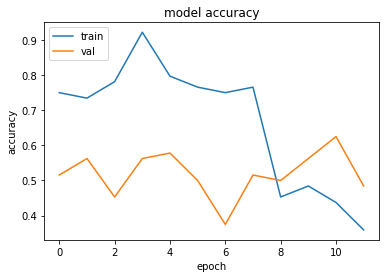

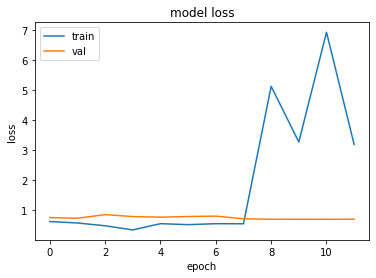

In [33]:
##print(history.history.keys())

# summarize history for accuracy
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
model_3.evaluate(testset)

474/474 [==============================] - 18s 37ms/step - loss: 0.6933 - categorical_accuracy: 0.5000


[0.6932733058929443, 0.5]

In [57]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [80]:
def create_confusion_matrix(y_true,y_predict):
  cm =confusion_matrix(y_true, y_predict)  
  print(cm)
  index = ['SAFE','ACCIDENTS']  
  columns = ['SAFE','ACCIDENTS']  
  cm_df = pd.DataFrame(cm,columns,index)                      
  plt.figure(figsize=(10,6))  
  sns.heatmap(cm_df, annot=True, fmt='g')

In [81]:
def compute_metrics(model,testset):
  
  y_true = [x[1] for x in list(testset.as_numpy_iterator())]
  y_true = np.concatenate(y_true,axis=0)
  y_true = np.array([int(x[0]) for x in y_true])
  y_predict = np.array([int(np.argmax(x)==0) for x in model.predict(testset)])

  print(len(y_true))
  print(len(y_predict))
  
  print(f"accuracy {accuracy_score(y_true,y_predict)}")

  print(f"precision {precision_score(y_true,y_predict)}")

  print(f"recall {recall_score(y_true,y_predict)}")

  print(f"f1_score {f1_score(y_true,y_predict)}")

  create_confusion_matrix(y_true,y_predict)


15168
15168
accuracy 0.5
precision 0.0
recall 0.0
f1_score 0.0
[[7584    0]
 [7584    0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


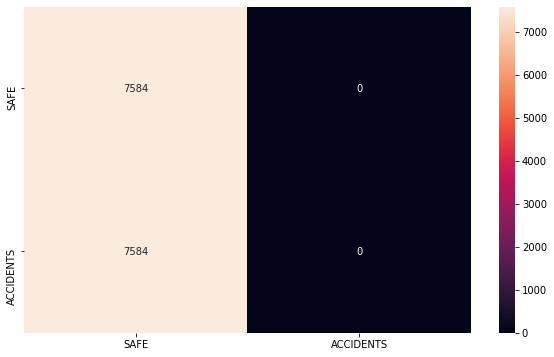

In [82]:
compute_metrics(model_3,testset)